In [16]:
import os
from pathlib import Path
import numpy as np
import cv2
from ultralytics import YOLO
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


0: 416x416 6 helmets, 125.3ms
Speed: 8.0ms preprocess, 125.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 helmet, 1 head, 59.0ms
Speed: 1.9ms preprocess, 59.0ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 2 helmets, 2 heads, 76.1ms
Speed: 2.3ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 helmet, 95.4ms
Speed: 1.9ms preprocess, 95.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 2 helmets, 94.7ms
Speed: 2.3ms preprocess, 94.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 3 helmets, 64.9ms
Speed: 1.8ms preprocess, 64.9ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 4 helmets, 80.7ms
Speed: 1.6ms preprocess, 80.7ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 2 helmets, 50.7ms
Speed: 1.4ms preprocess, 50.7ms inference, 0.8ms postprocess per

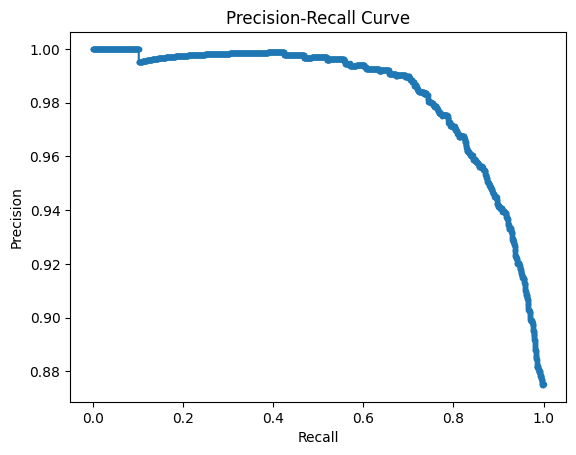

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
from sklearn.metrics import precision_recall_curve, average_precision_score

# Путь к весам модели и тестовым изображениям
weights_path = Path('/Users/muzafarov/Desktop/MyEducation/SafetyHelmetDetection/weights/yolov8n_baseline.pt')
test_images_dir = Path('/Users/muzafarov/Desktop/Datasets/SafetyHelmetDetection/test/images')
test_labels_dir = Path('/Users/muzafarov/Desktop/Datasets/SafetyHelmetDetection/test/labels')

# Загрузка модели
model = YOLO(weights_path)

# Классы, которые модель может предсказывать
class_names = ['helmet', 'head', 'person']

# Функция для вычисления IoU
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2
    
    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area

# Оценка модели
iou_threshold = 0.5
y_true = []
y_scores = []

for image_path in test_images_dir.glob('*.png'):  # Измените расширение, если необходимо
    # Загрузка изображения
    image = cv2.imread(str(image_path))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Предсказание модели
    results = model(image_rgb)
    if not results:  # Проверка на пустые результаты
        continue
    
    predictions = results[0].boxes.xyxy.cpu().numpy()
    confidences = results[0].boxes.conf.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()
    
    # Загрузка истинных аннотаций
    label_path = test_labels_dir / (image_path.stem + '.txt')
    if not label_path.exists():
        continue
    
    true_boxes = np.loadtxt(label_path).reshape(-1, 5)
    
    # Вычисление IoU и метрик
    for pred, conf, cls in zip(predictions, confidences, classes):
        x1_p, y1_p, x2_p, y2_p = pred[:4]
        pred_class = int(cls)
        max_iou = 0
        matched = False
        
        for true_box in true_boxes:
            true_class, x_center, y_center, width, height = true_box
            x1 = (x_center - width / 2) * image.shape[1]
            y1 = (y_center - height / 2) * image.shape[0]
            x2 = (x_center + width / 2) * image.shape[1]
            y2 = (y_center + height / 2) * image.shape[0]
            
            iou = compute_iou([x1, y1, x2, y2], [x1_p, y1_p, x2_p, y2_p])
            if iou > max_iou:
                max_iou = iou
                matched = (iou > iou_threshold and pred_class == int(true_class))
        
        y_true.append(1 if matched else 0)
        y_scores.append(conf)

# Проверка на пустые списки перед вычислением метрик
if not y_true or not y_scores:
    print("Нет данных для вычисления метрик.")
else:
    # Вычисление средних метрик
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    mean_precision = np.mean(precision)
    
    # Вывод результатов
    print(f'mAP: {ap:.4f}')
    print(f'Средняя Precision: {mean_precision:.4f}')
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

## Метрики

### mAP: 0.9830
### Средняя Precision: 0.9765
